In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score,confusion_matrix
from torch.utils.data import Dataset

# Load the dataset
data = pd.read_csv('filtered_data_equalRating_dist.csv')
data = data.dropna(subset=['review_text'])

dfs = []
generos = ['children','comics_graphics','fantasy_paranormal','history_biography','mystery_thriller_crime','poetry','romance','young_adult']

for genero in generos:
    dfs.append(data[data['type'] == genero].sample(n=150, random_state=1))
df_sampled = pd.concat(dfs).reset_index(drop=True)

# Encode the target labels (categories/genres)
label_encoder = LabelEncoder()
df_sampled['label'] = label_encoder.fit_transform(df_sampled['type'])

# Check the mapping from labels to original categories
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

# Sample a smaller subset of the data
# data_sampled = data.sample(frac=0.1, random_state=42)  # Use 10% of the data THIS WAS INACCURATE

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the reviews
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')

# Define Trainer object
# Ensure labels are of type torch.long
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        # Tokenize the review text at each index
        tokenized_review = tokenize_function(self.reviews.iloc[idx])
        
        # Extract input_ids and attention_mask from the tokenized review
        input_ids = tokenized_review['input_ids'].squeeze(0)
        attention_mask = tokenized_review['attention_mask'].squeeze(0)

        # Get the corresponding label for the review and ensure it's of type torch.long
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }
    
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_sampled['review_text'], df_sampled['label'], test_size=0.2, random_state=42)

# Create the training and testing datasets using the custom Dataset class
train_dataset = ReviewsDataset(X_train, y_train)
test_dataset = ReviewsDataset(X_test, y_test)

# Load pre-trained BERT model with a classification head (set the number of classes)
num_labels = len(df_sampled['label'].unique())  # Number of unique genres
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',           # output directory
    evaluation_strategy='epoch',      # evaluate during training
    per_device_train_batch_size=8,    # batch size for training
    per_device_eval_batch_size=16,    # batch size for evaluation
    num_train_epochs=3,               # number of training epochs
    weight_decay=0.01,                # strength of weight decay
)

def compute_metrics(pred):
    logits, labels = pred
    logits = torch.tensor(logits)  # Convert logits to tensor if they are not already
    predictions = torch.argmax(logits, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics = compute_metrics
)

# Train the model
trainer.train()

results = trainer.evaluate()
print(f"Evaluation results: {results}")

{'children': 0, 'comics_graphics': 1, 'fantasy_paranormal': 2, 'history_biography': 3, 'mystery_thriller_crime': 4, 'poetry': 5, 'romance': 6, 'young_adult': 7}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/joao/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

/home/joao/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.7282814979553223, 'eval_accuracy': 0.36666666666666664, 'eval_f1': 0.3259011946924429, 'eval_precision': 0.4984393838836347, 'eval_recall': 0.36666666666666664, 'eval_runtime': 1479.1354, 'eval_samples_per_second': 0.162, 'eval_steps_per_second': 0.01, 'epoch': 1.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.540996789932251, 'eval_accuracy': 0.44583333333333336, 'eval_f1': 0.4346889299108394, 'eval_precision': 0.4766988572684385, 'eval_recall': 0.44583333333333336, 'eval_runtime': 565.7406, 'eval_samples_per_second': 0.424, 'eval_steps_per_second': 0.027, 'epoch': 2.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.5149632692337036, 'eval_accuracy': 0.45416666666666666, 'eval_f1': 0.449254897045005, 'eval_precision': 0.45180899575464795, 'eval_recall': 0.45416666666666666, 'eval_runtime': 1588.8364, 'eval_samples_per_second': 0.151, 'eval_steps_per_second': 0.009, 'epoch': 3.0}
{'train_runtime': 50468.3068, 'train_samples_per_second': 0.057, 'train_steps_per_second': 0.007, 'train_loss': 1.4988801744249132, 'epoch': 3.0}


  0%|          | 0/15 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 1.5149632692337036, 'eval_accuracy': 0.45416666666666666, 'eval_f1': 0.449254897045005, 'eval_precision': 0.45180899575464795, 'eval_recall': 0.45416666666666666, 'eval_runtime': 1423.7455, 'eval_samples_per_second': 0.169, 'eval_steps_per_second': 0.011, 'epoch': 3.0}


  0%|          | 0/15 [00:00<?, ?it/s]

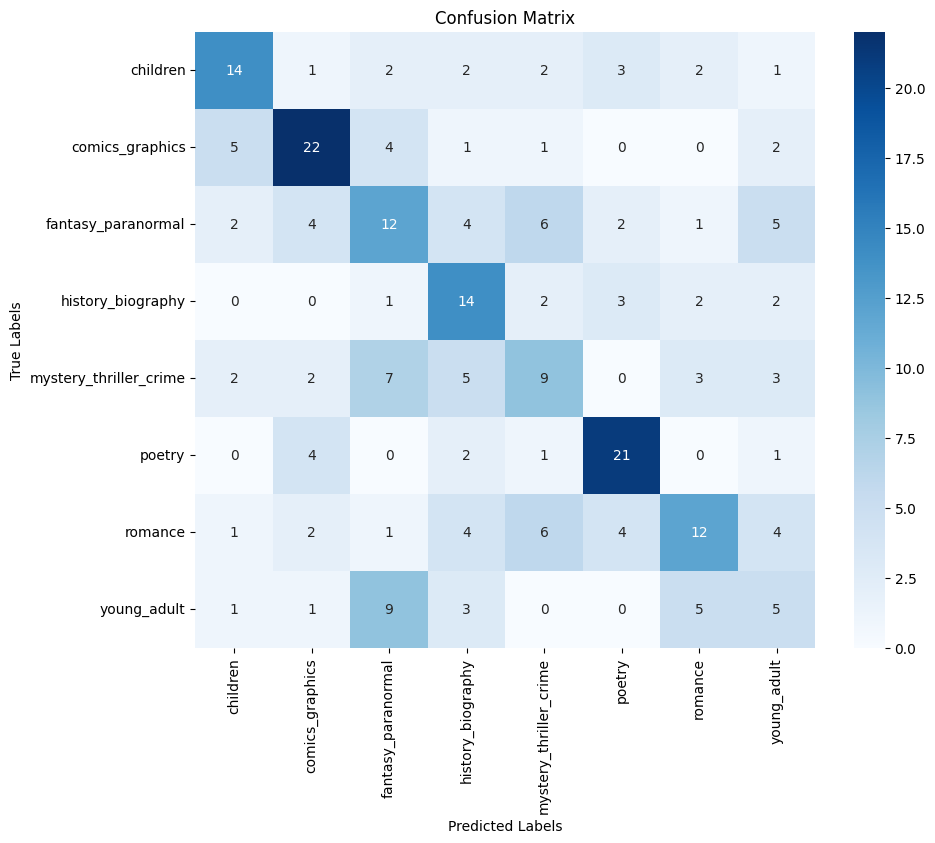

      Metric     Score
0   accuracy  0.454167
1         f1  0.449255
2  precision  0.451809
3     recall  0.454167


In [2]:
import pandas as pd

# Get predictions and true labels from the test set
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# Extract evaluation metrics
metrics = ['accuracy', 'f1', 'precision', 'recall']
scores = [results[f'eval_{metric}'] for metric in metrics]

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    "Metric": metrics,
    "Score": scores
})

# Display the table
print(metrics_df)


In [3]:
# Example of new reviews
new_reviews = ["This book was full of fantasy and magic.", 
               "The story was thrilling and action-packed."]

# Tokenize the new reviews
new_inputs = tokenizer(new_reviews, padding='max_length', truncation=True, return_tensors='pt')

# Predict the genre
outputs = model(**new_inputs)
predictions = torch.argmax(outputs.logits, dim=-1)

# Convert predictions back to genre labels
predicted_genres = label_encoder.inverse_transform(predictions)

# Display the predicted genres
for review, genre in zip(new_reviews, predicted_genres):
    print(f"Review: {review} -> Predicted Genre: {genre}")

Review: This book was full of fantasy and magic. -> Predicted Genre: children
Review: The story was thrilling and action-packed. -> Predicted Genre: fantasy_paranormal
